# Spam e-mails analysis

In [1]:
import numpy as np
import pandas as pd
import string
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
import itertools
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

The email dataset contains 5,572 messages, representing both spam and non-spam categories.

In [2]:
spam_dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'],
                           skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])
spam_dataset

,Spam,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [3]:
print(spam_dataset['Spam'].value_counts(normalize=True))

0    0.865937
1    0.134063
Name: Spam, dtype: float64


Only 13% of the emails represent spam messages, while the remaining messages are classified as non-spam. The data is not balanced. 

## Exploratory data analysis

In [4]:
def remove_puncation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(lambda x: remove_puncation(x))
spam_dataset

,Spam,Text,Cleaned_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...


In [5]:
def tokenize(text):

    # Usunięcie wielkich liter
    clean_text = text.lower()

    # Tokenizacja
    tokenized_text = nltk.word_tokenize(clean_text)
    return tokenized_text

spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(lambda x: tokenize(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,..."
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,..."


In [6]:
stopwords = nltk.corpus.stopwords.words("english")
#stopwords

In [7]:
def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords
spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(lambda x: remove_stopwords(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t..."
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b..."


In [8]:
stemmer = nltk.PorterStemmer()
def stemming(text):
    stemmed_words = [stemmer.stem(word) for word in text]
    return stemmed_words
spam_dataset['Stemmed_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: stemming(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text,Stemmed_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho..."
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po...","[2nd, time, tri, 2, contact, u, u, å£750, poun..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]","[ì, b, go, esplanad, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]","[piti, mood, soani, suggest]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b...","[guy, bitch, act, like, id, interest, buy, som..."


In [9]:
lemmater = nltk.WordNetLemmatizer()
def lemmatizing(text):
    lemmatized_words = [lemmater.lemmatize(word) for word in text]
    return lemmatized_words
spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: lemmatizing(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text,Stemmed_Text,Lemmatized_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho...","[nah, dont, think, go, usf, life, around, though]"
...,...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po...","[2nd, time, tri, 2, contact, u, u, å£750, poun...","[2nd, time, tried, 2, contact, u, u, å£750, po..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]","[ì, b, go, esplanad, fr, home]","[ì, b, going, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]","[piti, mood, soani, suggest]","[pity, mood, soany, suggestion]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b...","[guy, bitch, act, like, id, interest, buy, som...","[guy, bitching, acted, like, id, interested, b..."


### Wordcloud

In [10]:
words_spam = list(spam_dataset.loc[spam_dataset['Spam']==1, 'Lemmatized_Text'].values)
words_spam = list(itertools.chain.from_iterable(words_spam))
words_spam = ' '.join(words_spam)
words_notspam = list(spam_dataset.loc[spam_dataset['Spam']==0, 'Lemmatized_Text'].values)
words_notspam = list(itertools.chain.from_iterable(words_notspam))
words_notspam = ' '.join(words_notspam)

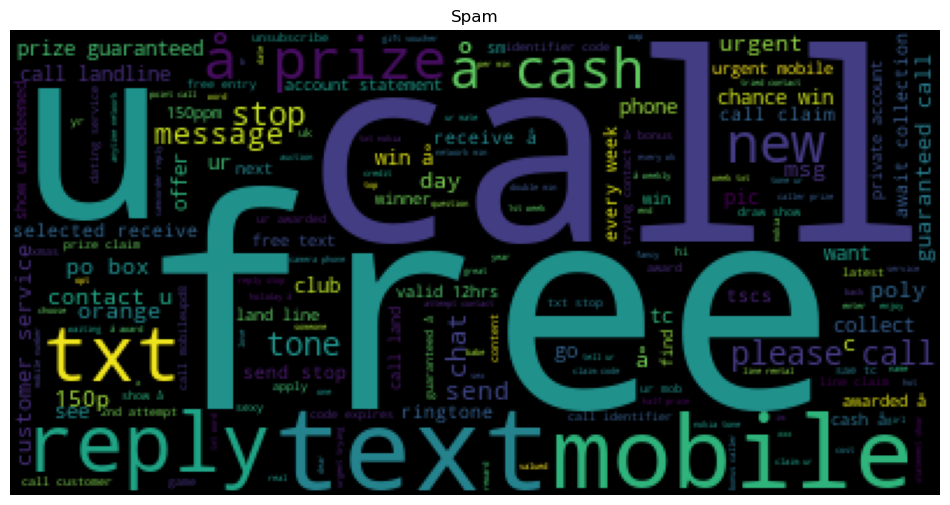

In [11]:
wordcloud = WordCloud().generate(words_spam)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Spam')
plt.show()

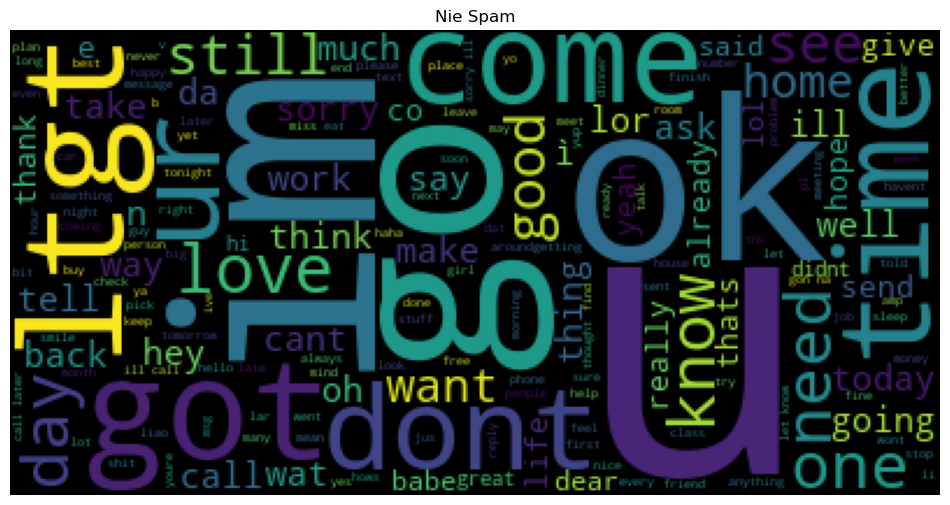

In [12]:
wordcloud = WordCloud().generate(words_notspam)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Nie Spam')
plt.show()

## Training/Testing split


In [14]:
spam_dataset['Lemmatized_String'] = spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x))

X=spam_dataset['Lemmatized_String']
y=spam_dataset['Spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, stratify=y, random_state=42)

## Vectorization

In [15]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
print(X_train_tfidf.shape)
X_test_tfidf = tfidf.transform(X_test)
print(X_test_tfidf.shape)

#tfidf.vocabulary_


(5542, 8818)
(30, 8818)


### Random Forest Algorithm

In [16]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tfidf, y_train)
rf.score(X_train_tfidf, y_train)

1.0

### Features importance

In [17]:
features = pd.DataFrame(tfidf.get_feature_names_out())
features['importance'] = rf.feature_importances_
selected_features = features[features['importance'] > 0.001].index.values.tolist()
len(selected_features)

153

In [18]:
# update the feature matrix
X_train_new = X_train_tfidf.toarray()[:,selected_features]
X_test_new = X_test_tfidf[:,selected_features]

Features with the importance score higher than 0.001 will be used for further analysis. The new dataset contains 153 features.

In [19]:
rf_feat_selec = RandomForestClassifier(random_state=42)

params = {
    'max_depth':[n for n in range(1,25,3)],
    'min_samples_split':[8,10,15,17,20],
    'min_samples_leaf':[2,5,7]
}

grid_search = GridSearchCV(rf_feat_selec, params, cv=10, n_jobs=-1, verbose=0, scoring='f1_macro')
grid_search.fit(X_train_new, y_train)
print('Selected hyperparameters:', grid_search.best_params_)
model_rf2 = grid_search.best_estimator_

Selected hyperparameters: {'max_depth': 22, 'min_samples_leaf': 2, 'min_samples_split': 20}


Calculating performace metrics.

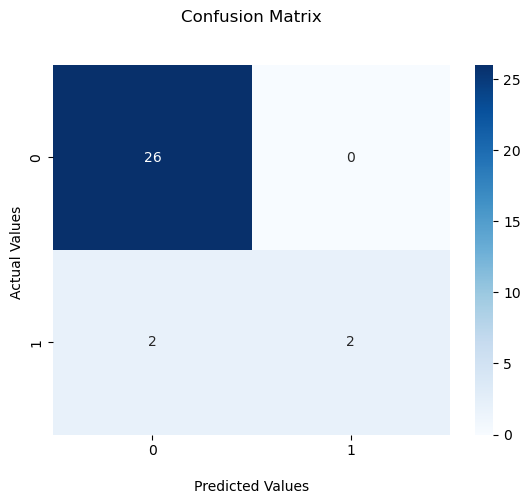

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        26
           1       1.00      0.50      0.67         4

    accuracy                           0.93        30
   macro avg       0.96      0.75      0.81        30
weighted avg       0.94      0.93      0.92        30



In [20]:
predictions = model_rf2.predict(X_test_new)

plt.figure()
cm = confusion_matrix(y_test, predictions)
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

print(classification_report(y_test, predictions))

### Features selection for the Count Vectorizer

In [21]:
count = CountVectorizer(min_df=0.01, max_df=0.5)
X_train_count = count.fit_transform(X_train)
X_test_count = count.transform(X_test)
#count.vocabulary_

In [22]:

# Random Forest Classifier 
rf_v2 = RandomForestClassifier(random_state=0)
rf_v2.fit(X_train_count, y_train)
rf_v2.score(X_train_count, y_train)

0.9895344640923854

In [23]:
features2 = pd.DataFrame(count.get_feature_names_out())
features2['importance'] = rf_v2.feature_importances_
selected_features2 = features2[features2['importance'] > 0.001].index.values.tolist()
len(selected_features2)

103

In [24]:
# update the feature matrix
X_train_count_new = X_train_count.toarray()[:,selected_features2]
X_test_count_new = X_test_count[:,selected_features2]
X_train_count_new.shape

(5542, 103)

In [25]:
grid_search2 = GridSearchCV(rf_feat_selec, params, cv=10, n_jobs=-1, verbose=0, scoring='f1_macro')
grid_search2.fit(X_train_count_new, y_train)
print('Selected hyperparameters:', grid_search2.best_params_)
model_count_rf2 = grid_search2.best_estimator_

Selected hyperparameters: {'max_depth': 22, 'min_samples_leaf': 2, 'min_samples_split': 17}


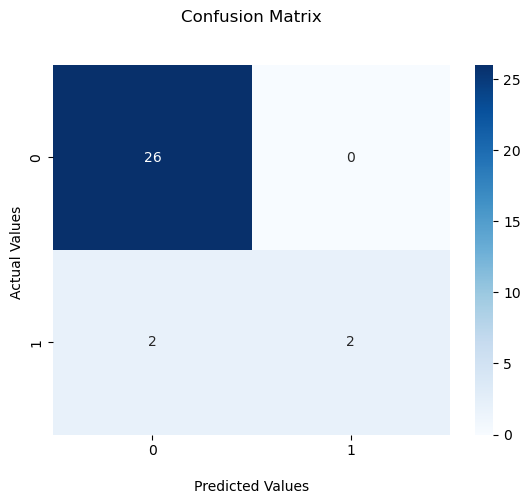

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        26
           1       1.00      0.50      0.67         4

    accuracy                           0.93        30
   macro avg       0.96      0.75      0.81        30
weighted avg       0.94      0.93      0.92        30



In [26]:
# metrics calculation
predictions_count = model_count_rf2.predict(X_test_count_new)

plt.figure()
cm = confusion_matrix(y_test, predictions_count)
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

print(classification_report(y_test, predictions_count))

Both vectorizer methods performed well, achieving identical prediction scores. The overall accuracy is 0.93, but the recall for both methods is only 0.5, indicating that only half of the spam emails were correctly classified.